In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import math

In [2]:
from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModel
import torchvision.transforms as T
import torch
from torch import nn

In [46]:
val_df = pd.read_pickle("data/CLEVR_v1.0/val-data.pkl")
# train_df = pd.read_pickle("data/CLEVR_v1.0/train-data.pkl")

In [47]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("Using: ", device)

Using:  cpu


In [48]:
text_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_encoder = AutoModel.from_pretrained("bert-base-uncased")
for p in text_encoder.parameters():
    p.requires_grad = False

image_processor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
image_encoder = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")
for p in image_encoder.parameters():
    p.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
if torch.cuda.device_count() > 1:
    print("Available GPU's: ", torch.cuda.device_count())
    image_encoder = nn.DataParallel(image_encoder)
    text_encoder = nn.DataParallel(text_encoder)


image_encoder.to(device)
text_encoder.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [50]:
class DeeperNewQAEarlyFusionNetwork(nn.Module):

    def __init__(self, hyperparms=None):

        super(DeeperNewQAEarlyFusionNetwork, self).__init__()        
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(64)
        self.classifier = nn.Linear(64, 28)
        W = torch.Tensor(768, 768)
        self.W = nn.Parameter(W)
        self.relu_f = nn.ReLU()
        # initialize weight matrices
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        
    def forward(self, image_emb, text_emb):

        x_img = image_emb   
        
        x_text = text_emb

        Xvt = x_img * x_text

        Xvt = self.relu_f(torch.mm(Xvt, self.W.t()))


        Xvt = self.fc1(Xvt)
        Xvt = self.bn1(Xvt)
        Xvt = self.relu_f(Xvt)
        Xvt = self.fc2(Xvt)
        Xvt = self.bn2(Xvt)
        Xvt = self.relu_f(Xvt)
        Xvt = self.fc3(Xvt)
        Xvt = self.bn3(Xvt)
        Xvt = self.relu_f(Xvt)
        Xvt = self.fc4(Xvt)
        Xvt = self.bn4(Xvt)
        Xvt = self.relu_f(Xvt)
        Xvt = self.dropout(Xvt)
        Xvt = self.classifier(Xvt)

        return Xvt

In [51]:
class NewQAEarlyFusionNetwork(nn.Module):

    def __init__(self, hyperparms=None):

        super(NewQAEarlyFusionNetwork, self).__init__()        
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.classifier = nn.Linear(256, 28) 
        W = torch.Tensor(768, 768)
        self.W = nn.Parameter(W)
        self.relu_f = nn.ReLU()
        # initialize weight matrices
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        
    def forward(self, image_emb, text_emb):

        x_img = image_emb   
        
        x_text = text_emb

        Xvt = x_img * x_text
        Xvt = self.relu_f(torch.mm(Xvt, self.W.t()))


        Xvt = self.fc1(Xvt)
        Xvt = self.bn1(Xvt)
        Xvt = self.relu_f(Xvt)
        Xvt = self.fc2(Xvt)
        Xvt = self.bn2(Xvt)
        Xvt = self.relu_f(Xvt)
        Xvt = self.dropout(Xvt)
        Xvt = self.classifier(Xvt)

        return Xvt

In [52]:
class BaseNetwork(nn.Module):

    def __init__(self, hyperparms=None):

        super(BaseNetwork, self).__init__()        
        self.dropout = nn.Dropout(0.3)
        self.vision_projection = nn.Linear(768, 768) 
        self.text_projection = nn.Linear(768, 768)
        self.fc1 = nn.Linear(768, 256) 
        self.bn1 = nn.BatchNorm1d(256)
        self.classifier = nn.Linear(256, 13) 
        W = torch.Tensor(768, 768)
        self.W = nn.Parameter(W)
        self.relu_f = nn.ReLU()
        # initialize weight matrices
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        
    def forward(self, image_emb, text_emb):

        x1 = image_emb   
        x1 = torch.nn.functional.normalize(x1, p=2, dim=1)
        Xv = self.relu_f(self.vision_projection(x1))
        
        x2 = text_emb
        x2 = torch.nn.functional.normalize(x2, p=2, dim=1)
        Xt = self.relu_f(self.text_projection(x2))

        Xvt = Xv * Xt
        Xvt = self.relu_f(torch.mm(Xvt, self.W.t()))

        Xvt = self.fc1(Xvt)
        Xvt = self.bn1(Xvt)
        Xvt = self.dropout(Xvt)
        Xvt = self.classifier(Xvt)

        return Xvt

In [53]:
answer_code_key = {'yes': 0,
 '2': 1,
 'no': 2,
 'rubber': 3,
 'large': 4,
 '0': 5,
 'sphere': 6,
 'gray': 7,
 'cube': 8,
 'blue': 9,
 'brown': 10,
 '1': 11,
 'yellow': 12,
 'purple': 13,
 'cylinder': 14,
 'small': 15,
 'green': 16,
 'metal': 17,
 '3': 18,
 '4': 19,
 'cyan': 20,
 '6': 21,
 'red': 22,
 '5': 23,
 '8': 24,
 '7': 25,
 '9': 26,
 '10': 27}

Image Name:  CLEVR_val_000019.png
Question Index:  192


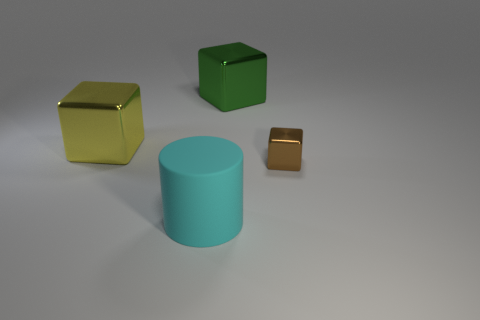

Question:  WHat color is the cylinder?


tensor(10)
ANSWER:  BROWN

 ******************************
Top 3 Probabilities:
brown ~ 2.2378170490264893
green ~ 1.109840989112854
yellow ~ 0.5982334017753601


In [54]:
from PIL import Image
import random
from collections import OrderedDict


query_df = val_df.iloc[:200]

idx = random.randint(0, len(query_df))

print("Image Name: ", query_df['image_filename'][idx])

# idx = 29028

# idx = 119481

# idx = 144593

# idx = 43314

print("Question Index: ", idx)

image_to_display = query_df['image'][idx]
question = query_df['question'][idx]
image = query_df['resized_image'][idx]
label = query_df['answer_code'][idx]

image_inputs = image_processor(image, return_tensors="pt")
image_inputs = {k:v.to(device) for k,v in image_inputs.items()}
image_outputs = image_encoder(**image_inputs)
image_embedding = image_outputs.pooler_output
image_embedding = image_embedding.view(-1)
image_embedding = image_embedding.detach()

from IPython.display import Image
display(image_to_display)

question = input()
print("Question: ", question)
# print("Grund Truth : ", label)
# print("Ground Truth: ", list(answer_code_key.keys())[list(answer_code_key.values()).index(label)].upper())

text_inputs = text_tokenizer(question, return_tensors="pt")
text_inputs = {k:v.to(device) for k,v in text_inputs.items()}
text_outputs = text_encoder(**text_inputs)
text_embedding = text_outputs.last_hidden_state[:,0,:]
text_embedding = text_embedding.view(-1)
text_embedding = text_embedding.detach()

encoding={}
encoding["image_emb"] = image_embedding
encoding["text_emb"] = text_embedding
encoding["label"] = torch.tensor(label)

batch = tuple(b.to(device) for b in encoding.values())
inputs = {'image_emb':  batch[0], 'text_emb': batch[1]} 
labels =  batch[2]

inputs['image_emb'] = inputs['image_emb'].view(1, -1)
inputs['text_emb'] = inputs['text_emb'].view(1, -1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# model_path = "base_models/easyvqa_finetuned_epoch_5.model"
# p_model = BaseNetwork()

# model_path = "exp7_models/epoch_11.model"
# p_model = DeeperNewQAEarlyFusionNetwork()

model_path = "exp3_models/epoch_5.model"
p_model = NewQAEarlyFusionNetwork()

check = torch.load(model_path, map_location=torch.device('cpu'))

new_state_dict = OrderedDict()

for k,v in check.items():
    k = k.replace('module.', '')
    new_state_dict[k] = v


# p_model.load_state_dict(torch.load(model_path))
p_model.load_state_dict(new_state_dict)
p_model.to(device)
p_model.eval()

with torch.no_grad():
    outputs = p_model(**inputs)

print("\n")
print(torch.argmax(outputs))
print("ANSWER: ", list(answer_code_key.keys())[list(answer_code_key.values()).index(torch.argmax(outputs).item())].upper())

print( "\n", "*" * 30)
print("Top 3 Probabilities:")
for arg, prob in zip(torch.argsort(outputs, descending=True).tolist()[0][:3], torch.sort(outputs, descending=True).values.tolist()[0][:3]):
    print(list(answer_code_key.keys())[list(answer_code_key.values()).index(arg)], '~', prob)

In [55]:
from PIL import Image
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

class EasyQADataset(Dataset):

    def __init__(self,df,
                 image_encoder, 
                 text_encoder,
                 image_processor, 
                 tokenizer,
              ):
        self.df = df
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.image_processor = image_processor
        self.tokenizer = tokenizer

        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        image = self.df['image'][idx]
        question = self.df['question'][idx] 
        label = self.df['answer_code'][idx]

        image_inputs = self.image_processor(image, return_tensors="pt")
        image_inputs = {k:v.to(device) for k,v in image_inputs.items()}
        image_outputs = self.image_encoder(**image_inputs)
        image_embedding = image_outputs.pooler_output
        image_embedding = image_embedding.view(-1)
        image_embedding = image_embedding.detach()

        text_inputs = self.tokenizer(question, return_tensors="pt")
        text_inputs = {k:v.to(device) for k,v in text_inputs.items()}
        text_outputs = self.text_encoder(**text_inputs)
        text_embedding = text_outputs.last_hidden_state[:,0,:]
        text_embedding = text_embedding.view(-1)
        text_embedding = text_embedding.detach()

        encoding={}
        encoding["image_emb"] = image_embedding
        encoding["text_emb"] = text_embedding
        encoding["label"] = torch.tensor(label)

        return encoding


In [56]:

import random
from torch import nn
from tqdm.notebook import tqdm
import numpy as np
import requests

criterion = nn.CrossEntropyLoss()

model = p_model

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals, confidence = [], [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch.values())
        
        inputs = {'image_emb':  batch[0],'text_emb': batch[1]}  

        with torch.no_grad():        
            outputs = model(**inputs)
            
        labels =  batch[2]  
        loss = criterion(outputs.view(-1, 28), labels.view(-1))
        loss_val_total += loss.item()

        probs   = torch.max(outputs.softmax(dim=1), dim=-1)[0].detach().cpu().numpy()
        outputs = outputs.argmax(-1)
        logits = outputs.detach().cpu().numpy()
        label_ids = labels.cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        confidence.append(probs)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    confidence = np.concatenate(confidence, axis=0)
            
    return loss_val_avg, predictions, true_vals, confidence

In [57]:
test_dataset = EasyQADataset(
                           df=val_df.iloc[:1000],
                           image_encoder = image_encoder,
                           text_encoder = text_encoder,
                           tokenizer = text_tokenizer,
                           image_processor = image_processor
                           )

In [58]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_test = DataLoader(test_dataset, 
                            sampler=SequentialSampler(test_dataset), 
                            batch_size=128)

_, preds, truths, confidence = evaluate(dataloader_test)

In [59]:
ourmodel_preds = preds

In [67]:
ourmodel_preds_backup = ourmodel_preds

In [16]:
from sklearn.metrics import accuracy_score

def accuracy_score_func(preds, labels):
    return accuracy_score(labels, preds)

In [60]:
print("Test Acc: ", accuracy_score_func(ourmodel_preds,truths))

Test Acc:  0.522


In [76]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(truths, ourmodel_preds, labels=np.unique(truths))


In [73]:
pd.Series(ourmodel_preds).to_csv("ourpreds.csv")

In [77]:
cm.shape

(25, 25)

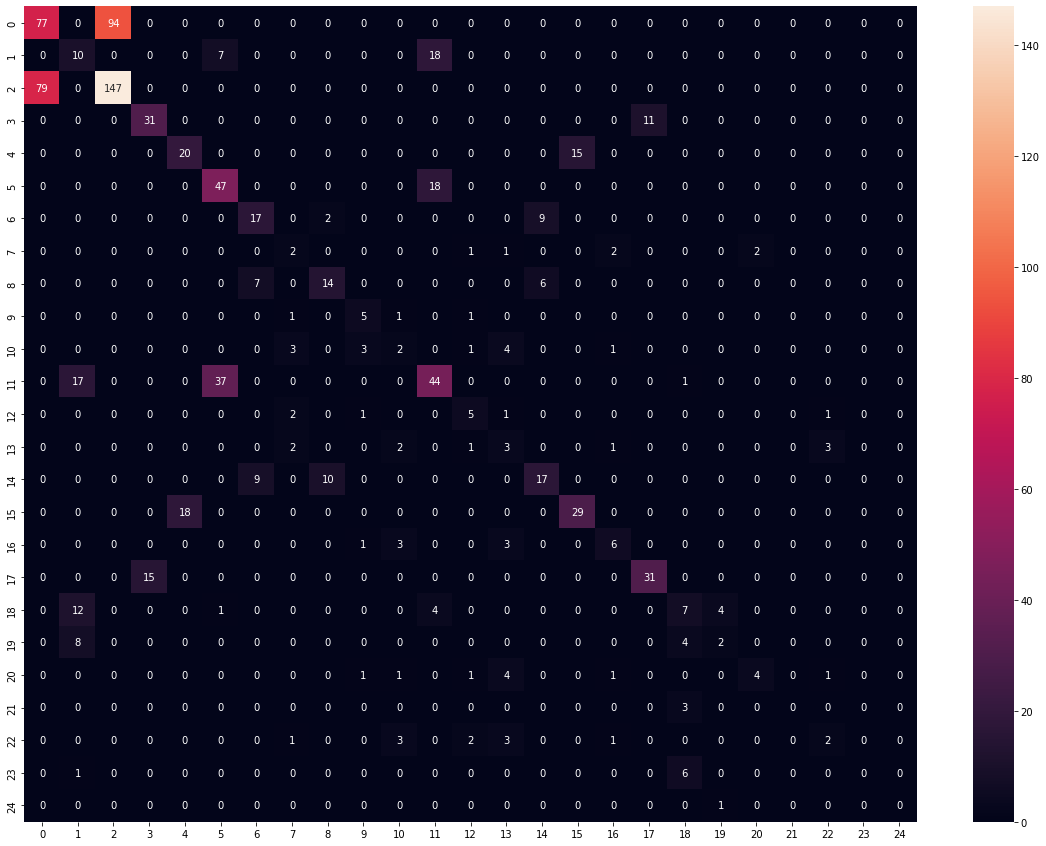

In [89]:
import seaborn as sns

plt.figure(figsize=(20,15))

ax = sns.heatmap(cm, annot=True, fmt='g');

plt.show()

In [18]:
print("Test Acc: ", accuracy_score_func(preds,truths))

Test Acc:  0.522


## Evaluating GPV Ouputs

In [6]:
gpv_predictions = pd.read_csv("gpv_predicted_ans.csv")

In [7]:
test_set_og = pd.read_csv("data/CLEVR_v1.0/new_val_df.csv")

In [15]:
from sklearn.metrics import accuracy_score

def accuracy_score_func(preds, labels):
    return accuracy_score(labels, preds)

In [63]:
gpv_preds = gpv_predictions["predicted_answer"]
labels = test_set_og["answer"]

print("Test Acc: ", accuracy_score_func(gpv_preds, labels))

Test Acc:  0.296


In [43]:
test_set_og["answer"].nunique()

25

In [45]:
gpv_predictions["predicted_answer"].value_counts()[:20].sum()

935

In [33]:
replacements = {
    "square": "cube",
    "circle" : "sphere",
    "ball" : "sphere",
    "round" : "sphere",
    "oval" : "sphere",
    "cylindrical": "cylinder",
    "big": "large",
    "giant" : "large",
    "plastic" : "metal",
    "silver" : "gray",
    
}

In [38]:
gpv_predictions["cleaned_preds"] = gpv_predictions["predicted_answer"].apply(lambda x: replacements[x].strip() if x in replacements.keys() else x.strip())

In [39]:
gpv_predictions["predicted_answer"].nunique()

62

In [40]:
gpv_predictions["cleaned_preds"].nunique()

55

In [41]:
cleaned_gpv_preds = gpv_predictions["cleaned_preds"]
labels = test_set_og["answer"]

print("Test Acc: ", accuracy_score_func(cleaned_gpv_preds, labels))

Test Acc:  0.343


In [16]:
from collections import OrderedDict
new_state_dict = OrderedDict()

In [ ]:
for k,v in check.items():
    k = k.replace('module.', '')
    new_state_dict[k] = v
